In [1]:
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('wine-quality').getOrCreate()

In [2]:
red = spark.read.option("delimiter", ";").csv('./winequality-red.csv', header='true', inferSchema='true')
# white = spark.read.option("delimiter", ";").csv('./winequality-white.csv', header='true', inferSchema='true')

red.printSchema()
red.show()
red.count()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|          

1599

In [3]:
train, test = red.randomSplit([0.8, 0.2])
train.count()
test.count()

302

# Exploratory Data Analysis

In [4]:
from pyspark.sql.functions import kurtosis, skewness

labelCol = 'quality'

train.select(labelCol).describe().show()
train.groupby(labelCol).count().orderBy(labelCol).show()

train.agg(skewness(labelCol)).show()
train.agg(kurtosis(labelCol)).show()
# Last parameter is error tolerance
quantile = train.approxQuantile(labelCol, [0.25, 0.50, 0.75], 0.05)
quantileFrame = spark.createDataFrame([quantile], ['25%', '50%', '75%'])
quantileFrame.show()
train.stat.freqItems([labelCol], 0.1).show()

+-------+------------------+
|summary|           quality|
+-------+------------------+
|  count|              1297|
|   mean| 5.644564379336932|
| stddev|0.8123013427008758|
|    min|                 3|
|    max|                 8|
+-------+------------------+

+-------+-----+
|quality|count|
+-------+-----+
|      3|    9|
|      4|   41|
|      5|  547|
|      6|  521|
|      7|  163|
|      8|   16|
+-------+-----+

+------------------+
| skewness(quality)|
+------------------+
|0.2060672760453426|
+------------------+

+------------------+
| kurtosis(quality)|
+------------------+
|0.3442122072008047|
+------------------+

+---+---+---+
|25%|50%|75%|
+---+---+---+
|5.0|5.0|6.0|
+---+---+---+

+------------------+
| quality_freqItems|
+------------------+
|[8, 5, 4, 7, 3, 6]|
+------------------+



In [5]:
f = train.groupby('citric acid').count().orderBy('count')
display(f)

DataFrame[citric acid: double, count: bigint]

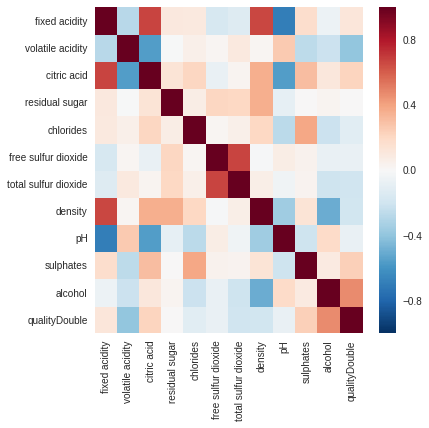

In [6]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

changedTrain = train.withColumn(labelCol+'Double', train[labelCol].cast("double")).drop(labelCol)

numericCols = changedTrain.columns

corrAssembler = VectorAssembler(inputCols=numericCols, outputCol='corrFeatures')
corrTrain = corrAssembler.transform(changedTrain)
corrMat = Correlation.corr(corrTrain, 'corrFeatures').head()

pdf = corrMat[0].toArray()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

sns.heatmap(pdf, 
            xticklabels=numericCols,
            yticklabels=numericCols)

In [31]:
from pyspark.sql.functions import stddev_pop, var_pop

cols = train.columns[:]
cols.remove(labelCol)

stddev_pops = [stddev_pop(column).alias(column) for column in cols]

df = train.agg(*stddev_pops)
df.show()

+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+
|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|          sulphates|           alcohol|
+------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+
|1.7618861827779646|0.18124344462306716|0.19613651920559713|1.4764446618871485|0.04700997850496999| 10.320615569480212|   32.77617418526506|0.001911213690499...|0.15417811187295102|0.16809657987705923|1.0791931326940123|
+------------------+-------------------+-------------------+------------------+-------------------+-----------------

In [8]:
%%script false
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

cols = train.columns[:]
cols.remove(labelCol)

assembler = VectorAssembler(inputCols=cols, outputCol="assembledFeatures")
scalers = StandardScaler(inputCol="assembledFeatures", outputCol="features", withStd=True, withMean=True)
pca = PCA(k=5, inputCol="features", outputCol="pcaFeatures")
pipeline = Pipeline(stages=[assembler, scalers, pca])
model = pipeline.fit(train)
pcaTrain = model.transform(train)
pcaTrain.select("features", "pcaFeatures").show()

There's some moderate correlation between 'citric acid' and 'fixed acidity', 'free sulfur dioxide' and 'total sulfur dioxide', 'fixed acidity' and 'density'

In [9]:
train

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

# Classifiers

In [10]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

accuracyDataFrame = pd.DataFrame(columns=['Train', 'Test'])

## Regressor

In [11]:
# %%script false 
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

cols = train.columns[:]
cols.remove(labelCol)

gbtRegressorTrain = train

assembler = VectorAssembler(inputCols=cols, outputCol='features')
regressor = GBTRegressor(labelCol='quality')
pipeline = Pipeline(stages=[assembler, regressor])
grid = ParamGridBuilder().addGrid(regressor.maxIter, [5, 10, 15]).build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = RegressionEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(gbtRegressorTrain)
gbtRegressorTrain = model.transform(gbtRegressorTrain)
gbtRegressorTest = model.transform(test)

evaluator = RegressionEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(gbtRegressorTrain, {evaluator.metricName: "r2"})
testAccuracy = evaluator.evaluate(gbtRegressorTest, {evaluator.metricName: "r2"})
accuracyDataFrame.loc['GBTRegressor'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.692448,0.284893


## RandomForestClassifier

In [12]:
from pyspark.ml.classification import RandomForestClassifier

cols = train.columns[:]
cols.remove(labelCol)

randomForestClassifierTrain = train
randomForestClassifierTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = RandomForestClassifier(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.maxDepth, [3, 5])\
                         .addGrid(classifier.numTrees, [20, 50])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(randomForestClassifierTrain)
randomForestClassifierTrain = model.transform(randomForestClassifierTrain)
randomForestClassifierTest = model.transform(randomForestClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(randomForestClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(randomForestClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['RandomForestClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.692448,0.284893
RandomForestClassifier,0.684657,0.678808


In [13]:
from pyspark.ml.classification import LogisticRegression

cols = train.columns[:]
cols.remove(labelCol)

logisticRegressionTrain = train
logisticRegressionTest = test

assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = LogisticRegression(labelCol='quality')
pipeline = Pipeline(stages=[assembler, classifier])
grid = ParamGridBuilder().addGrid(classifier.regParam, [0.1, 0.15])\
                         .addGrid(classifier.maxIter, [100, 200, 300])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality'),
                          numFolds=10)
model = crossval.fit(logisticRegressionTrain)
logisticRegressionTrain = model.transform(logisticRegressionTrain)
logisticRegressionTest = model.transform(logisticRegressionTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality')

trainAccuracy = evaluator.evaluate(logisticRegressionTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(logisticRegressionTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['LogisticRegression'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.692448,0.284893
RandomForestClassifier,0.684657,0.678808
LogisticRegression,0.570547,0.639073


## MultilayerPerceptronClassifier

In [14]:
from pyspark.ml.pipeline import Estimator, Model, Pipeline
from pyspark.ml.param.shared import *
from pyspark.sql.functions import min

class HasMin(Params):
    minimum = Param(Params._dummy(), "minimum", "minimum")

    def __init__(self):
        super(HasMin, self).__init__()

    def setMin(self, value):
        return self._set(minimum=value)

    def getMin(self):
        return self.getOrDefault(self.minimum)

class MinTransformation(Estimator, HasInputCol, 
        HasOutputCol, HasMin):

    def _fit(self, dataset):
        c = self.getInputCol()
        self.minimum = dataset.agg(min(c)).first()[0]
        return (MinTransformationModel()
            .setInputCol(c)
            .setMin(self.minimum)
            .setOutputCol(self.getOutputCol()))

class MinTransformationModel(Model, HasInputCol, HasOutputCol, HasMin):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getOutputCol()
        minimum = self.getMin()
        meta = {'MinTransformation' : minimum}
        return dataset.withColumn(y, (col(x) - minimum).alias(y, metadata=meta))

class HasConst(Params):
    const = Param(Params._dummy(), "const", "const")

    def __init__(self):
        super(HasConst, self).__init__()

    def setConst(self, value):
        return self._set(const=value)

    def getConst(self):
        return self.getOrDefault(self.const)

class ConstTransformation(Estimator, HasInputCol, 
        HasOutputCol, HasConst):

    def _fit(self, dataset):
        c = self.getInputCol()
        for f in dataset.schema.fields:
            if 'MinTransformation' in f.metadata:
                self.const = f.metadata['MinTransformation']
                break
        
        return (ConstTransformationModel()
            .setInputCol(c)
            .setConst(self.const)
            .setOutputCol(self.getOutputCol()))

class ConstTransformationModel(Model, HasInputCol, HasOutputCol, HasConst):

    def _transform(self, dataset):
        x = self.getInputCol()
        y = self.getOutputCol()
        const = self.getConst()

        return dataset.withColumn(y, col(x) + const)


In [15]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

cols = train.columns[:]
cols.remove(labelCol)

mlpClassifierTrain = train
mlpClassifierTest = test

minTransformation = MinTransformation().setInputCol('quality').setOutputCol('reQuality')
assembler = VectorAssembler(inputCols=cols, outputCol='features')
classifier = MultilayerPerceptronClassifier(labelCol='reQuality')
constTransformation = ConstTransformation().setInputCol('prediction').setOutputCol('actualPrediction')

pipeline = Pipeline(stages=[minTransformation, assembler, classifier, constTransformation])
grid = ParamGridBuilder().addGrid(classifier.maxIter, [100, 200])\
                         .addGrid(classifier.layers, [[11, 10, 10, 6], [11, 20, 10, 6]])\
                         .build()
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps = grid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='quality', predictionCol='actualPrediction'),
                          numFolds=10)

model = crossval.fit(mlpClassifierTrain)
mlpClassifierTrain = model.transform(mlpClassifierTrain)
mlpClassifierTest = model.transform(mlpClassifierTest)

evaluator = MulticlassClassificationEvaluator(labelCol='quality', predictionCol='actualPrediction')

trainAccuracy = evaluator.evaluate(mlpClassifierTrain, {evaluator.metricName: "accuracy"})
testAccuracy = evaluator.evaluate(mlpClassifierTest, {evaluator.metricName: "accuracy"})

accuracyDataFrame.loc['MultilayerPerceptronClassifier'] = [trainAccuracy, testAccuracy]
accuracyDataFrame

,Train,Test
GBTRegressor,0.692448,0.284893
RandomForestClassifier,0.684657,0.678808
LogisticRegression,0.570547,0.639073
MultilayerPerceptronClassifier,0.589052,0.579470
